# Exploración de conversaciones de U-Cursos

Foro institucional de ingeniería:

- 1,376,786 mensajes
- 96,667 temas (96,421 temas existentes?)
- hay 246 temas que al parecer ya no existen
- 11,341 usuarios
- desde el 2002-03-11 12:16:44 al 2019-08-01 12:44:51

### Cargar librerías

In [1]:
%load_ext sql
%env DATABASE_URL=mysql+mysqlconnector://root@localhost/ucursos

env: DATABASE_URL=mysql+mysqlconnector://root@localhost/ucursos


In [170]:
from collections import defaultdict, Counter

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm
from datetime import datetime

import spacy
import pickle

from unionfind import UnionFind
from typing import List, Set, Tuple

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [15, 5]

import statistics

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout


from dataclasses import dataclass

In [42]:
# para explorar una lista

def summarize(l: List[int]):
    print("Size:", len(l), sep="\t")
    print("Min:", min(l), sep="\t")
    print("Median:", statistics.median(l), sep="\t")
    print("Max:", max(l), sep="\t")
    print("Avg:", sum(l) / len(l), sep="\t")
    print("Mode:", statistics.mode(l), sep="\t")

### Mensajes en el periodo 2018-04-01 -- 2018-07-01 (11,883 mensajes)

In [54]:
%%sql mensajes <<

SET @date_init = '2018-04-01';
SET @date_end = '2018-07-01';

SELECT * 
FROM MENSAJES_INGENIERIA m 
     JOIN 
     GENERO g 
        ON m.MEN_RUT = g.ID
WHERE MEN_CENSURADO = 0
AND DATE(MEN_FECHA_CREACION) >= @date_init 
AND DATE(MEN_FECHA_CREACION) < @date_end
;

 * mysql+mysqlconnector://root@localhost/ucursos
0 rows affected.
0 rows affected.
11883 rows affected.
Returning data to local variable mensajes


In [55]:
df = mensajes.DataFrame()

In [65]:
df.head()

,MEN_ID,MEN_TEM_ID,MEN_TEM_NOMBRE,MEN_MEN_ID,MEN_RUT,MEN_TITULO,MEN_CONTENIDO,MEN_CENSURADO,MEN_RAIZ,MEN_FECHA_CREACION,MEN_ULTIMO_MEN_ID,MEN_AUTORIDAD,MEN_FECHA_M,MEN_INSTITUCIONES,ID,GENERO
0,2114559,36,Temas Generales,0,1,Actividades docentes del día jueves 19 de abri...,Considerando que la Escuela ha recibido una so...,0,0,2018-04-18 22:25:31,2114559,0,2018-04-19 09:34:56,,1,M
1,2130775,36,Temas Generales,0,1,Declaración FCFM: Sobre paralización de la Fac...,Estimadas y estimados estudiantes:\r\n\r\nEn m...,0,0,2018-06-08 14:57:30,2131599,0,2018-06-11 22:59:19,,1,M
2,2119127,36,Temas Generales,0,43,[VENDO] Iphone 6 64GB,"Hola,\r\n\r\nestoy vendiendo un Iphone 6 de 64...",0,0,2018-05-03 16:24:38,2119127,0,2018-05-03 18:09:04,,43,M
3,2120077,36,Temas Generales,0,43,Vendo IPHONE 6 de 64GB,"Hola,\r\n\r\nestoy vendiendo un Iphone 6 de 64...",0,0,2018-05-07 11:13:21,2120077,0,2018-05-07 11:13:21,,43,M
4,2136847,36,Temas Generales,2136833,83,Re (11): [+1/comente] Adiós -1,+1##@@##2078,0,2136809,2018-06-20 11:27:11,0,0,2018-06-20 11:27:11,,83,M


In [66]:
print("cantidad de temas en el periodo")
len(df.loc[df.MEN_MEN_ID == 0].index)

cantidad de temas en el periodo


1362

###  Todos los mensajes en el dataset (1,376,437 mensajes)

In [44]:
%%sql mensajes_all <<

SELECT * 
FROM MENSAJES_INGENIERIA m JOIN GENERO g ON m.MEN_RUT = g.ID
WHERE MEN_CENSURADO = 0;

 * mysql+mysqlconnector://root@localhost/ucursos
1376437 rows affected.
Returning data to local variable mensajes_all


In [45]:
df_all = mensajes_all.DataFrame()

### Consulta para ver un Tema

In [51]:
%%sql

SET @msg_id = '2154653';

select MEN_ID, MEN_TITULO, MEN_MEN_ID
from MENSAJES_INGENIERIA
where MEN_ID = @msg_id

union

select  MEN_ID,
        MEN_TITULO,
        MEN_MEN_ID
from    (select * from MENSAJES_INGENIERIA
         order by MEN_MEN_ID, MEN_ID) mensajes_sorted,
        (select @pv := @msg_id) initialisation
where   find_in_set(MEN_MEN_ID, @pv)
and     length(@pv := concat(@pv, ',', MEN_ID))
;


 * mysql+mysqlconnector://root@localhost/ucursos
0 rows affected.
5 rows affected.


MEN_ID,MEN_TITULO,MEN_MEN_ID
2154653,Calculadora cientifica,0
2154673,Re (1): Calculadora cientifica,2154653
2154675,Re (2): Calculadora cientifica,2154673
2154677,Re (3): Calculadora cientifica,2154675
2154679,Re (4): Calculadora cientifica,2154677


### Union Find para generar temas (dataset completo)

In [48]:
# generar temas usando union find
# usamos todos los mensajes del dataset ya que puede haber temas iniciados
# antes de que filtraramos el periodo de interes

uf = UnionFind()

for _, row in tqdm(df_all.iterrows(), total=len(df_all.index)):
    if row.MEN_MEN_ID == 0:
        uf.add(int(row.MEN_ID))
        
for _, row in tqdm(df_all.iterrows(), total=len(df_all.index)):
    if row.MEN_MEN_ID != 0:
        uf.union(int(row.MEN_ID), int(row.MEN_MEN_ID))

In [52]:
%%time
temas = list(uf.components())

CPU times: user 2min 48s, sys: 3.01 s, total: 2min 51s
Wall time: 3min 48s


In [53]:
# guardar uf, temas

with open('../data/python/uf.pkl', 'wb') as f:
    pickle.dump(uf, f)
    
with open('../data/python/temas.list.pkl', 'wb') as f:
    pickle.dump(temas, f)


In [ ]:
# cargar uf, temas

with open('../data/python/uf.pkl', 'rb') as f:
    uf = pickle.load(f)
    
with open('../data/python/temas.list.pkl', 'rb') as f:
    temas = pickle.load(f)

In [ ]:
temas = [frozenset(tema) for tema in temas]

In [73]:
print(len(temas))

96667


In [74]:
temas[0]

frozenset({2204304, 2204408, 2204410, 2204412, 2204420, 2204476, 2204480})

In [60]:
mensajes_por_tema = [len(tema) for tema in temas]
summarize(mensajes_por_tema)

# tema con 139 mensajes: https://www.u-cursos.cl/ingenieria/2/foro_institucion/o/37888

Size:	96667
Min:	1
Median:	6
Max:	139
Avg:	14.241499167244251
Mode:	1


In [67]:
# identificar mensajes que son la raiz de un tema

raices = set()
for _, row in tqdm(df_all.iterrows(), total=len(df_all.index)):
    if row.MEN_MEN_ID == 0:
        raices.add(int(row.MEN_ID))
        
len(raices) # al parecer hay temas sin raiz (men_men_id != 0)

96421

In [68]:
# titulos[msg_id: int] => title: str
titulos = dict()

for r in tqdm(raices):
    titulos[r] = df_all.loc[df_all.MEN_ID == r].iloc[0]['MEN_TITULO']

In [69]:
# guardar titulos

with open('../data/python/titulos.dict.pkl', 'wb') as f:
    pickle.dump(titulos, f)

In [ ]:
# cargar titulos

with open('../data/python/titulos.dict.pkl', 'rb') as f:
    titulos = pickle.load(f)

In [85]:
# tema_raiz[tema: set] => raiz: int
# raiz_tema[raiz: int] => tema: set

tema_raiz = dict()
raiz_tema = dict()
temas_no_raiz = []

for tema in tqdm(temas):
    raiz = False
    for msg in tema:
        if msg in raices:
            if raiz:
                print(f"tema {tema} tiene dos raices")
            tema_raiz[tema] = msg
            raiz_tema[msg] = tema
            raiz = True
    if not raiz:
        temas_no_raiz.append(tema)

In [81]:
len(temas_no_raiz) # al parecer estos temas ya no existen

246

In [87]:
def get_titulo(tema):
    raiz = tema_raiz[tema]
    return titulos[raiz]
        
get_titulo(raiz_tema[2154653])
titulos[2154653]

'Calculadora cientifica'

In [163]:
# mensaje_data[msg] => (rut: int, genero: str)  asociar id de usuario y genero a los mensajes

mensaje_data = dict()

for _, row in tqdm(df_all.iterrows(), total=len(df_all.index)):
    mensaje_data[row.MEN_ID] = (row.MEN_RUT, row.GENERO, row.MEN_FECHA_CREACION)

In [164]:
with open('../data/python/mensaje_data.dict.pkl', 'wb') as f:
    pickle.dump(mensaje_data, f)

In [165]:
mensaje_data[2154673]  # !

(8602, 'F', Timestamp('2018-08-24 21:33:00'))

In [168]:
m_ = mensaje_data[2154673]  # !
m_[2].to_pydatetime()

datetime.datetime(2018, 8, 24, 21, 33)

In [101]:
# crear pares (m1, m2) donde m1 responde a m2
# responde_a[msg_id: int] => msg_id
responde_a = dict()

for _, row in tqdm(df_all.iterrows(), total=len(df_all.index)):
    if row.MEN_MEN_ID != 0:
        responde_a[row.MEN_ID] = row.MEN_MEN_ID

In [102]:
with open('../data/python/responde_a.dict.pkl', 'wb') as f:
    pickle.dump(responde_a, f)

In [103]:
# conversaciones := listas de pares (m1, m2) donde m1 responde a m2
## cada lista corresponde a un tema
# conversaciones: List[(msg_id: int, msg_id: int)]
conversaciones = []

for tema in tqdm(temas):
    conversaciones.append([(m, responde_a[m]) for m in tema if m in responde_a])

In [104]:
with open('../data/python/conversaciones.list.pkl', 'wb') as f:
    pickle.dump(conversaciones, f)

# crear estructuras

In [179]:
Pair = Tuple[int, int]

@dataclass
class Tema:
    raiz: int
    titulo: str
    mensajes: Set[int]
    conversacion: Set[Pair]
    fecha_creacion: datetime
        
    def __eq__(self, o):
        if not isinstance(o, Tema):
            return NotImplemented
        return self.raiz == o.raiz
    
    def __len__(self):
        return len(self.mensajes)
    
    def __hash__(self):
        return self.raiz
    
    def __str__(self):
        return f"Tema(raiz={self.raiz}, titulo='{self.titulo}', mensajes={len(self.mensajes)}, conversaciones={len(self.conversacion)}, fecha_creacion='{self.fecha_creacion}')"

    def __repr__(self):
        return self.__str__()
    
    
@dataclass
class Mensaje:
    id_: int
    contenido: str
    autor: int
    genero: str
    es_raiz: bool
    fecha_creacion: datetime
    
    def __eq__(self, o):
        if not isinstance(o, Mensaje):
            return NotImplemented
        return self.id_ == o.id_
    
    def __hash__(self):
        return self.id_

In [180]:
temas_o = dict()

for tema in tqdm(temas):
    raiz = tema_raiz.get(tema)
    if not raiz:
        continue
    titulo = titulos.get(raiz)
    conversacion = [(m, responde_a[m]) for m in tema if m in responde_a]
    fecha_creacion = mensaje_data[raiz][2].to_pydatetime()
    temas_o[raiz] = Tema(raiz, titulo, tema, conversacion, fecha_creacion)

In [188]:
temas_o[list(raices)[1]]

Tema(raiz=1835011, titulo='Vendo Impresora láser, WIFI, a $30.000', mensajes=1, conversaciones=0, fecha_creacion='2015-12-07 13:27:42')

In [184]:
mensajes_o = dict()

for _, row in tqdm(df_all.iterrows(), total=len(df_all.index)):
    id_ = row['MEN_ID']
    cont = row['MEN_CONTENIDO']
    autor = row['MEN_RUT']
    gen = row['GENERO']
    es_raiz = id_ in raices
    fecha_creacion = row['MEN_FECHA_CREACION'].to_pydatetime()
    
    mensajes_o[id_] = Mensaje(id_, cont, autor, gen, es_raiz, fecha_creacion)

In [189]:
mensajes_o[1835011]

Mensaje(id_=1835011, contenido='Hola, estoy vendiendo esta impresora http://www.ripley.cl/ripley-chile/multifuncional-samsung-sl-m2020w-xbh-2000354220305p\r\nEsta 100% nueva, en su caja.\r\n\r\nEl precio de referencia en Ripley.cl es de $50.000\r\n\r\nLa entrega es en Beauchef 851\r\nCualquier duda o consulta, este es mi correo febrito@ing.uchile.cl##@@##2078', autor=955, genero='M', es_raiz=True, fecha_creacion=datetime.datetime(2015, 12, 7, 13, 27, 42))

In [182]:
with open('../data/python/temas.obj.pkl', 'wb') as f:
    pickle.dump(temas_o, f)

In [190]:
with open('../data/python/mensajes.obj.pkl', 'wb') as f:
    pickle.dump(mensajes_o, f)

In [ ]:
# cargar uf
# uf: UnionFind
#with open('../data/python/uf.pkl', 'rb') as f:
#    uf = pickle.load(f)
    
# temas: list[frozenset[int]]
#with open('../data/python/temas.list.pkl', 'rb') as f:
#    temas = pickle.load(f)
#    temas = [frozenset(tema) for tema in temas]
    
# titulos[msg_id: int] => title: str
#with open('../data/python/titulos.dict.pkl', 'rb') as f:
#    titulos = pickle.load(f)
    
# mensaje_data[msg] => (rut: int, genero: str)  asociar id de usuario y genero a los mensajes
#with open('../data/python/mensaje_data.dict.pkl', 'rb') as f:
#    mensaje_data = pickle.load(f)

In [18]:
print(max(enumerate(conversaciones), key=lambda i: len(conversaciones[i[0]])))
len(conversaciones[2975])

(2975, [(2123265, 2123179), (2123779, 2123767), (2123267, 2123179), (2123269, 2123179), (2123785, 2123779), (2123277, 2123179), (2123279, 2123179), (2123281, 2123179), (2123283, 2123179), (2123795, 2123785), (2123797, 2123635), (2123297, 2123179), (2123809, 2123779), (2123813, 2123179), (2123311, 2123179), (2123313, 2123179), (2123319, 2123179), (2123321, 2123179), (2123323, 2123179), (2123335, 2123179), (2123349, 2123179), (2123357, 2123179), (2123361, 2123179), (2123363, 2123179), (2123367, 2123179), (2123375, 2123179), (2123889, 2123709), (2123891, 2123635), (2123379, 2123179), (2123381, 2123179), (2123385, 2123179), (2123387, 2123179), (2123901, 2123709), (2123389, 2123179), (2123907, 2123635), (2123397, 2123179), (2123399, 2123179), (2123911, 2123779), (2123403, 2123179), (2123917, 2123889), (2123415, 2123179), (2123417, 2123179), (2123419, 2123179), (2123437, 2123179), (2123439, 2123179), (2123453, 2123179), (2123973, 2123179), (2123979, 2123795), (2123989, 2123625), (2123993, 21

100

In [19]:
i = 2975
print(conversaciones[i])
print(temas[i])
for m in temas[i]:
    print(m, mensaje_data[m], sep=" ")
    if m in raices:
        print("raiz:", m)

[(2123265, 2123179), (2123779, 2123767), (2123267, 2123179), (2123269, 2123179), (2123785, 2123779), (2123277, 2123179), (2123279, 2123179), (2123281, 2123179), (2123283, 2123179), (2123795, 2123785), (2123797, 2123635), (2123297, 2123179), (2123809, 2123779), (2123813, 2123179), (2123311, 2123179), (2123313, 2123179), (2123319, 2123179), (2123321, 2123179), (2123323, 2123179), (2123335, 2123179), (2123349, 2123179), (2123357, 2123179), (2123361, 2123179), (2123363, 2123179), (2123367, 2123179), (2123375, 2123179), (2123889, 2123709), (2123891, 2123635), (2123379, 2123179), (2123381, 2123179), (2123385, 2123179), (2123387, 2123179), (2123901, 2123709), (2123389, 2123179), (2123907, 2123635), (2123397, 2123179), (2123399, 2123179), (2123911, 2123779), (2123403, 2123179), (2123917, 2123889), (2123415, 2123179), (2123417, 2123179), (2123419, 2123179), (2123437, 2123179), (2123439, 2123179), (2123453, 2123179), (2123973, 2123179), (2123979, 2123795), (2123989, 2123625), (2123993, 2123795),

# Grafos de conversaciones


In [20]:
@dataclass
class Mensaje:
    msg_id: int
    autor_id: int
    genero: str
    es_raiz: bool = False

In [35]:
def create_conversacion_obj(conversacion):
    conv_obj = []
    for m1, m2 in conversacion:
        data_m1 = mensaje_data.get(m1)
        data_m2 = mensaje_data.get(m2)
        msg1 = Mensaje(msg_id=m1, autor_id=data_m1[0], genero=data_m1[1], es_raiz=(m1 in raices))
        msg2 = Mensaje(msg_id=m2, autor_id=data_m2[0], genero=data_m2[1], es_raiz=(m2 in raices))
        conv_obj.append((msg1, msg2))
    
    return conv_obj

In [22]:
co = create_conversacion_obj(conversaciones[i])
co

[(Mensaje(msg_id=2123265, autor_id=8602, genero='F', es_raiz=False),
  Mensaje(msg_id=2123179, autor_id=5410, genero='F', es_raiz=True)),
 (Mensaje(msg_id=2123779, autor_id=6262, genero='F', es_raiz=False),
  Mensaje(msg_id=2123767, autor_id=10246, genero='M', es_raiz=False)),
 (Mensaje(msg_id=2123267, autor_id=6456, genero='F', es_raiz=False),
  Mensaje(msg_id=2123179, autor_id=5410, genero='F', es_raiz=True)),
 (Mensaje(msg_id=2123269, autor_id=7080, genero='F', es_raiz=False),
  Mensaje(msg_id=2123179, autor_id=5410, genero='F', es_raiz=True)),
 (Mensaje(msg_id=2123785, autor_id=6174, genero='F', es_raiz=False),
  Mensaje(msg_id=2123779, autor_id=6262, genero='F', es_raiz=False)),
 (Mensaje(msg_id=2123277, autor_id=10240, genero='F', es_raiz=False),
  Mensaje(msg_id=2123179, autor_id=5410, genero='F', es_raiz=True)),
 (Mensaje(msg_id=2123279, autor_id=9731, genero='F', es_raiz=False),
  Mensaje(msg_id=2123179, autor_id=5410, genero='F', es_raiz=True)),
 (Mensaje(msg_id=2123281, auto

In [23]:
G = nx.DiGraph()

for m1, m2 in co:
    G.add_node(m1.msg_id, **vars(m1))
    G.add_node(m2.msg_id, **vars(m2))
    G.add_edge(m1.msg_id, m2.msg_id)

node_colors = ['green' if G.node[node_id]['genero'] == 'M' else 'orange' for node_id in G.nodes()]    

/Users/mquezada/anaconda3/envs/u-cursos/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/mquezada/anaconda3/envs/u-cursos/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


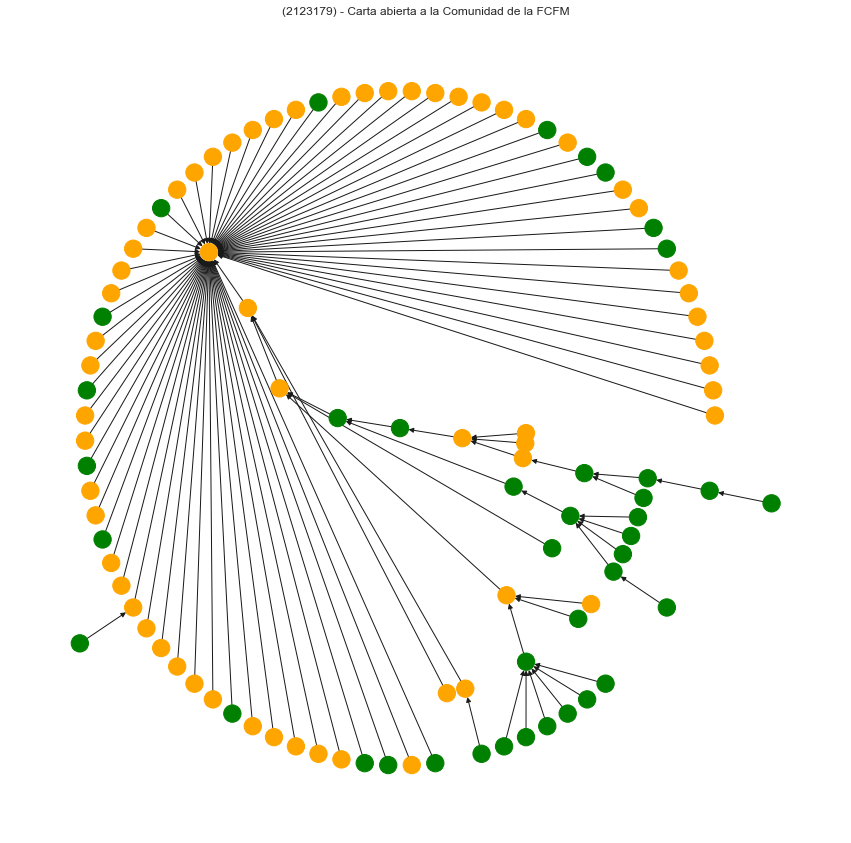

In [24]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.title(get_titulo(temas[i]))
pos = graphviz_layout(G, prog='twopi')
nx.draw(G, pos, node_color=node_colors, with_labels=False, arrows=True, font_weight='bold')

### Distribución de temas con % de participación de mujeres (cuidado con normalización por cantidad de mensajes en el thread)

In [27]:
%%time
conv_objs = [create_conversacion_obj(c) for c in conversaciones]

CPU times: user 289 ms, sys: 17.8 ms, total: 307 ms
Wall time: 310 ms


In [40]:
def get_generos(tema):
    for msg in tema:
        _, genero = mensaje_data.get(msg, (None, None))
        if genero:
            yield genero

In [41]:
genero_temas = []
for tema in temas:
    generos_temas.append(list(get_generos(tema)))